In [104]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import pickle
plt.rcParams['figure.figsize'] = 15, 10

# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
	torchvision.transforms.Normalize((0.5), (0.5))
])








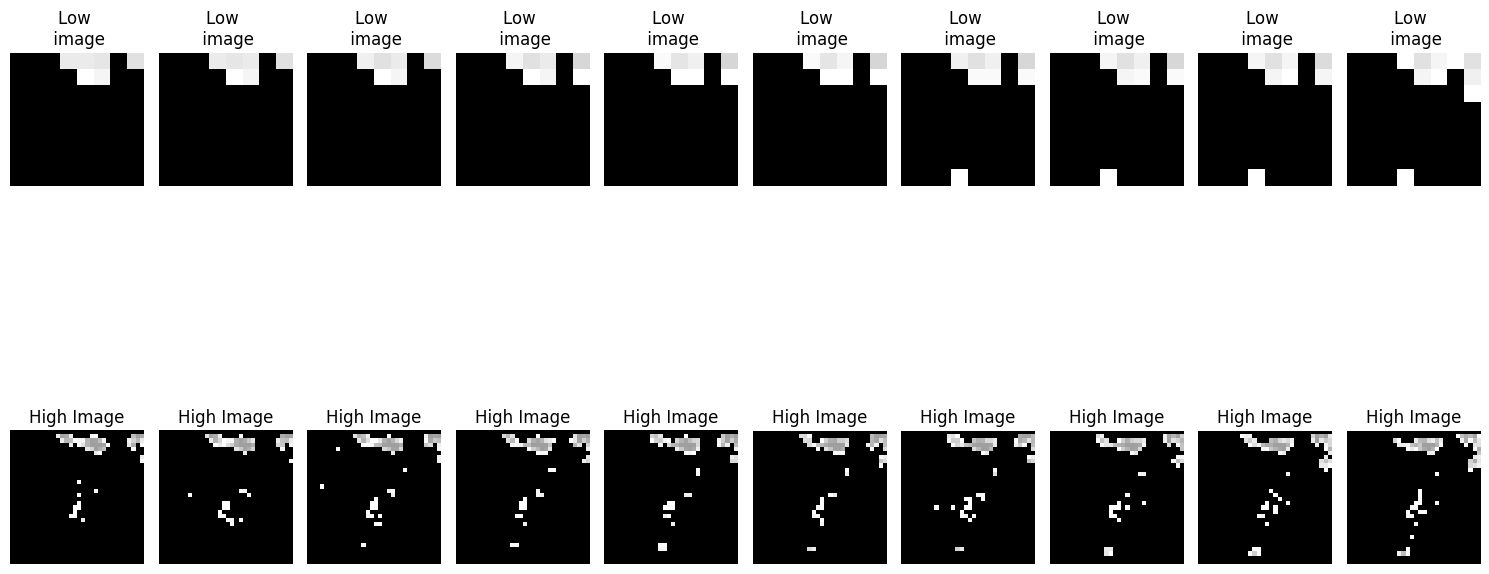

In [105]:
# load pickle file from ../data/scratch/img_pairs.pkl
with open("../../data/scratch/img_pairs.pkl", "rb") as f:
	train_dataset = pickle.load(f)

transformed_train_dataset = [(transform(image), transform(label)) for image, label in train_dataset]

n = len(transformed_train_dataset)
train_data = transformed_train_dataset[:int(n*0.9)]
val_data = transformed_train_dataset[int(n*0.9):]



counter = 1




for idx in range(10):
	idx = idx + 150
	val = transformed_train_dataset[idx][0]
	plt.subplot(2, 10, counter)
	plt.title("Low \n image")
	plt.imshow(val.reshape(8, 8), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

for idx in range(10):
    idx = idx + 150
    val = transformed_train_dataset[idx][1]
    plt.subplot(2, 10, counter)
    plt.imshow(val.reshape(32, 32), cmap='gray')
    plt.title("High Image")
    plt.axis('off')

	# Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()


In [122]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(64, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 256),
			torch.nn.ReLU(),
   			torch.nn.Linear(256, 512),
			torch.nn.ReLU(),
   			torch.nn.Linear(512, 768),
			torch.nn.ReLU(),
			torch.nn.Linear(768, 32 * 32),
			torch.nn.Sigmoid()
		)

	
	def decode(self, x):
		return self.decoder(x)
	def forward(self, x):
		
		decoded = self.decode(x)
		return decoded

# Instantiating the model and hyperparameters
model = DeepAutoencoder()
model = model.to('cuda')
criterion = torch.nn.MSELoss()
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [129]:
import random


def chunks(lst, n):
    random.shuffle(lst)
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# List that will store the training loss
train_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}

batch_size = 2048

b2 = []

for batch in train_data:
			
		# Loading image(s) and
		# reshaping it into a 1-d vector
		img, img2 = batch
		img = img.to('cuda')
		img2 = img2.to('cuda')
		b2.append((img, img2))

# split b2 in to batch_size chunks



batch_count = 0

# Training loop starts
for epoch in range(num_epochs):
	
	# Initializing variable for storing
	# loss
	running_loss = 0
	b2_batches = list(chunks(b2, batch_size))
	# Iterating over the training dataset
	for batch_output in b2_batches:
		
		
		img_batch = torch.stack([batch[0] for batch in batch_output]).reshape(-1, 8*8)
		img_label_batch = torch.stack([batch[1] for batch in batch_output]).reshape(-1, 32*32)
  
		out = model(img_batch)
			
		loss = criterion(out, img_label_batch)
		
		# Updating weights according
		# to the calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Incrementing loss
		running_loss += loss.item()
		batch_count += 1
	
	# Averaging out loss over entire batch
	running_loss /= batch_count
	train_loss.append(running_loss)
	print(f"{running_loss} {epoch}")
	# Storing useful images and
	# reconstructed outputs for the last batch
	outputs[epoch+1] = {'img': img, 'out': out}





0.9160996818542481 0
0.4580535835027695 1
0.3053614882628123 2
0.22901583045721055 3
0.1832138159275055 4
0.1526777736345927 5
0.1308709602696555 6
0.11451065346598625 7
0.10178572919633654 8
0.09160815644264221 9
0.08327926982532848 10
0.07633886277675629 11
0.07047043937903184 12
0.06543351471424103 13
0.061073537429173784 14
0.05725340820848942 15
0.05388462459339815 16
0.05089113023546007 17
0.04821338101437217 18
0.045801274538040164 19
0.04362434801601228 20
0.041638534339991484 21
0.039831347828326015 22
0.03816885694861412 23
0.03664356746673584 24
0.03523371403033917 25
0.03392820375937003 26
0.032716513786997116 27
0.03158790497944273 28
0.03053671669960022 29
0.02954922403058698 30
0.02862727738916874 31
0.0277599201780377 32
0.026943285219809588 33
0.02617210044179644 34
0.025444894366794164 35
0.024757920890241057 36
0.024106338086881136 37
0.023488079064931625 38
0.022901849746704103 39
0.022342672406173335 40
0.02181047028019315 41
0.021304190242013264 42
0.0208186187256

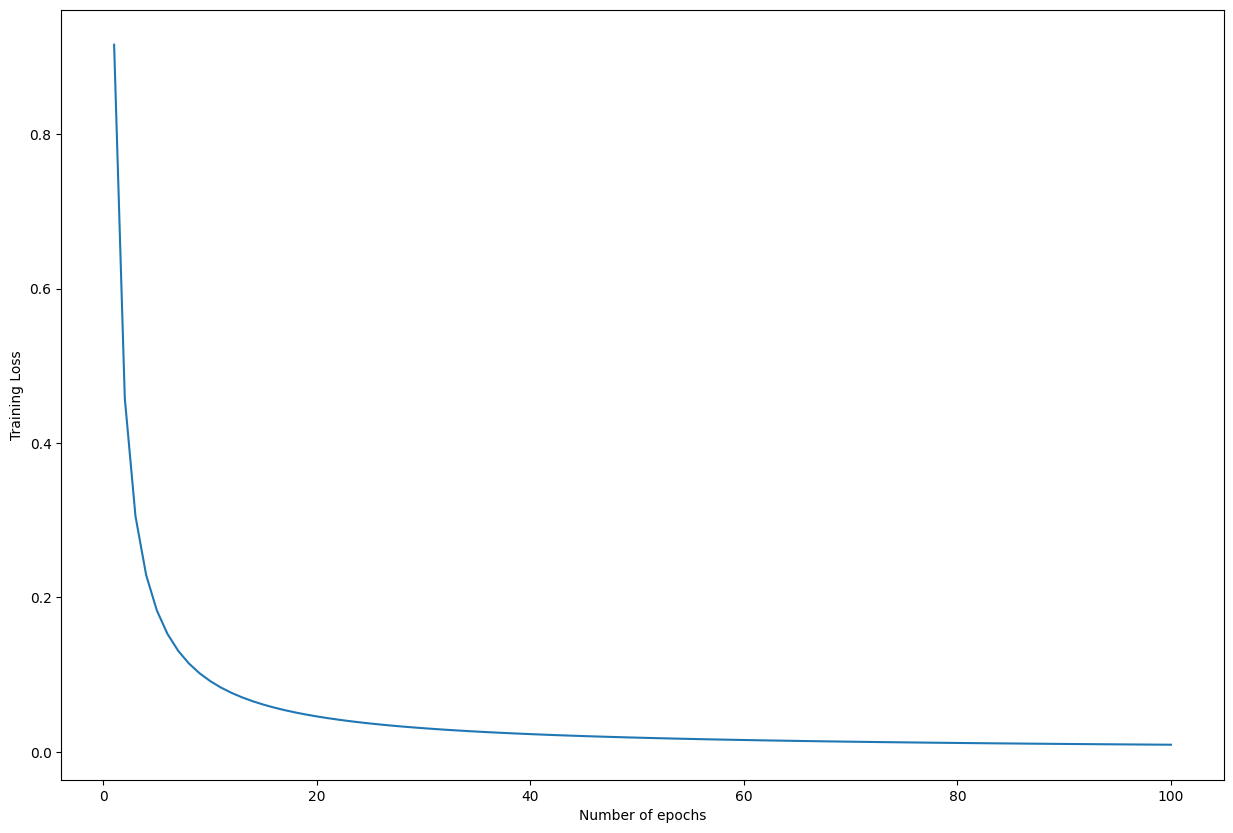

In [130]:
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

ValueError: cannot reshape array of size 1269760 into shape (32,32)

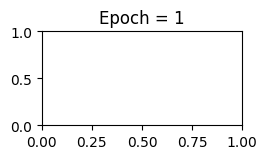

In [131]:
# Plotting is done on a 7x5 subplot
# Plotting the reconstructed images

# Initializing subplot counter
counter = 1

# Plotting reconstructions
# for epochs = [1, 5, 10, 50, 100]
epochs_list = [1, 5, 10, 50]

# Iterating over specified epochs
for val in epochs_list:
	
	# Extracting recorded information
	temp = outputs[val]['out'].detach().cpu().numpy()
	title_text = f"Epoch = {val}"
	
	# Plotting first five images of the last batch
	for idx in range(4):
		plt.subplot(7, 5, counter)
		plt.title(title_text)
		plt.imshow(temp.reshape(32,32), cmap= 'gray')
		plt.axis('off')
		
		# Incrementing the subplot counter
		counter+=1

	# Plotting original images

	# Iterating over first five
	# images of the last batch
	for idx in range(4):
		
		# Obtaining image from the dictionary
		
		temp = outputs[val]['img'].detach().cpu().numpy()
		# Plotting image
		plt.subplot(7,5,counter)
		plt.imshow(temp.reshape(8, 8),
				cmap = 'gray')
		plt.title("Original Image")
		plt.axis('off')
		
		# Incrementing subplot counter
		counter+=1

plt.tight_layout()
plt.show()


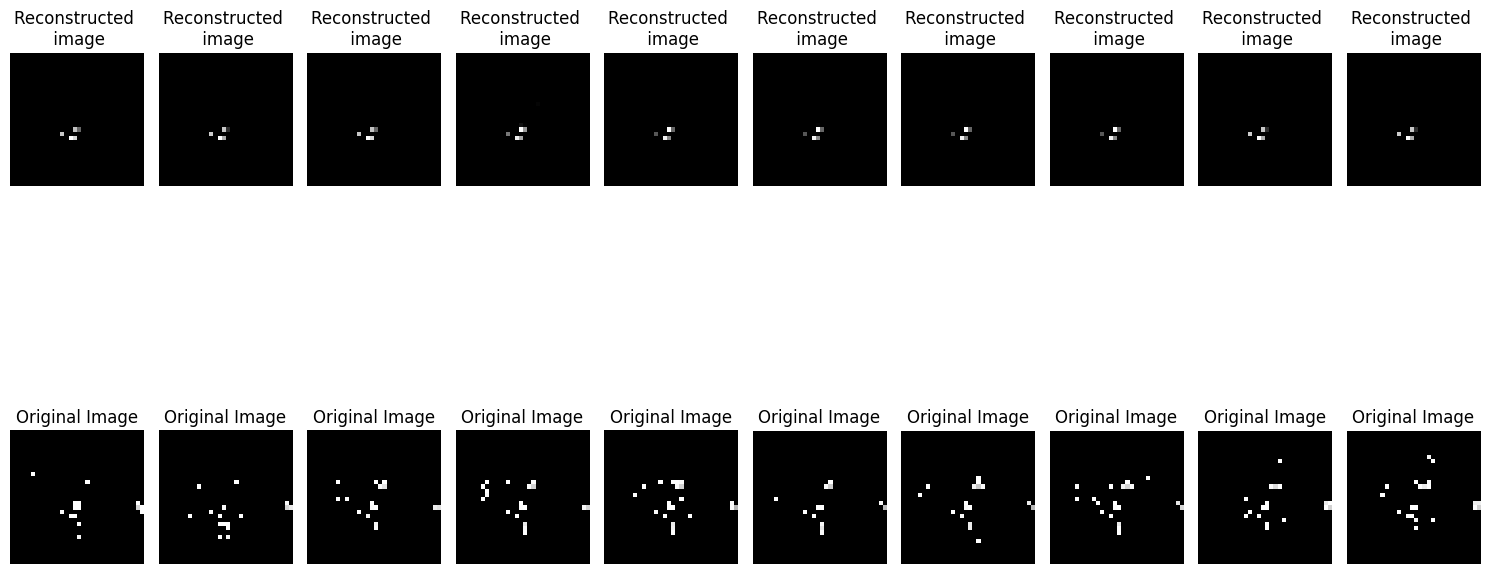

In [138]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the last batch from the test
# dataset
validation_data = val_data[1000:1020]

scored_images = []


for val_item in validation_data:	
	
	to_score = val_item[0].reshape(-1, 8*8)
	to_score = to_score.to('cuda')
	scored = model.decode(to_score)
	
	scored_images.append((val_item[1], scored))


# Generating output for the obtained
# batch


counter = 1


# Plotting first 10 images of the batch
for idx in range(len(validation_data)):
	plt.subplot(2, 10, counter)
	plt.title("Reconstructed \n image")
	plt.imshow(scored_images[idx][1].cpu().detach().reshape(32, 32), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

# Plotting original images

# Plotting first 10 images
for idx in range(len(validation_data)):
    
    plt.subplot(2, 10, counter)
    plt.imshow(scored_images[idx][0].reshape(32, 32), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

	# Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'RADAR_UPSCALER.pth')

In [ ]:
model2 = DeepAutoencoder()
model2.load_state_dict(torch.load('RADAR_UPSCALER.pth'))
model2 = model.to('cuda')  # Don't forget to move the model to GPU if available